In [18]:
import xarray as xr
import numpy as np
import dask
import pandas as pd
import xwmb
import xwmt
import xgcm
import warnings
warnings.filterwarnings('ignore')
import math

import numpy as np
import regionate
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cftime
from datetime import datetime
print(xwmb.__version__, xwmt.__version__, xgcm.__version__)

0.2.2 0.2.2 0.8.2.dev15+g7492277


In [19]:
mt_path = "/pub/mariant3/WarmWaterMasses/data/"
ocetrac_labels = xr.open_dataset(f"{mt_path}/ocetracv9/ocetrac-v9-blobs-tos-t1-r1-msq0-01860315-01891214-region.nc", chunks={'time':1})
labels = ocetrac_labels.blobs.load()

wmt = xr.open_dataset(
    f"{mt_path}WMT_data/0186-0189_wmt-daily.nc").sel(
    time=slice("0186","0189")
)

budgets = xr.open_dataset(
    f"{mt_path}budgets/7day_rolling_budgets/yearly-mhw-wmt-budgets-7d-rolling-mask_0186-0189.nc"
)
budgets_sum = budgets.sum("mhw").load()

In [3]:
# old_budgets corresponds to the 3-day rolling mask approach
# old_budgets = xr.open_dataset(f"{mt_path}budgets/rolling_budgets/rolling_budgets_v9/yearly-mhw-wmt-budgets-rolling-mask_0186-0189.nc")

In [20]:
id = 373 # 6608 3593 4091 4756 2265 1338 1467 2223

In [21]:
t1= "0186-04"
t2= "0186-11-15"

In [22]:
mhw_time_window = wmt.sel(time=slice(t1,t2)) # mainly used for the indices part

### Approach 1: Getting ∂M directly from the `xwmb` output by summing water masses >29

In [23]:
deltaM_manso_layer_mass = (
    wmt.sel(time=slice(t1,t2))
    .layer_mass.where(wmt.thetao_l_target > 29)
    .sum("thetao_l_target")
)

deltaM_budgets_layer_mass = (
    budgets_sum.sel(time=slice(t1,t2))
    .layer_mass.where(budgets_sum.thetao_l_target > 29)
    .sum("thetao_l_target")
)
deltaM_event_layer_mass = (
    budgets.sel(mhw=id).sel(time=slice(t1,t2))
    .layer_mass.where(budgets.sel(mhw=id).thetao_l_target > 29)
    .sum("thetao_l_target")
)

### Approach 2: Getting ∂M from integrating ∂M/∂t

In [24]:
deltaM_manso_dmdt = (
    (wmt['mass_tendency'] * 86400)
    .cumsum('time')
    .interp(thetao_l_target=29)
    .sel(time=slice(t1,t2))
)

deltaM_budgets_dmdt = (
    (budgets_sum['mass_tendency'] * 86400)
    .cumsum('time')
    .interp(thetao_l_target=29)
    .sel(time=slice(t1,t2))
)

deltaM_event_dmdt = (
    (budgets.sel(mhw=id)['mass_tendency'] * 86400)
    .cumsum('time')
    .interp(thetao_l_target=29)
    .sel(time=slice(t1,t2))
)

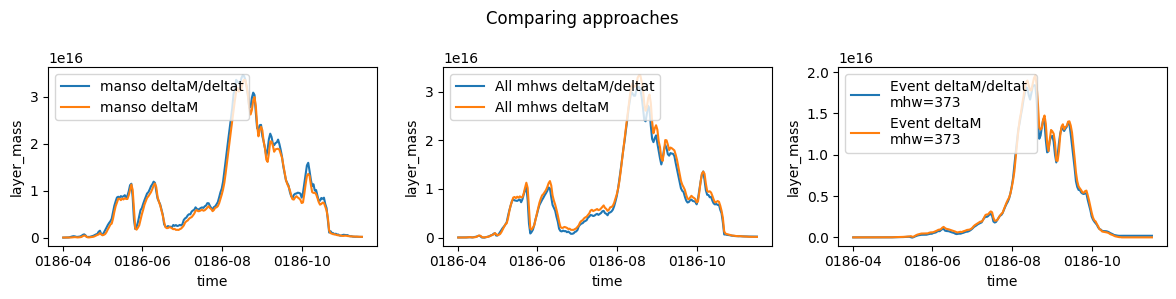

In [25]:
plt.figure(figsize=(12,3))

plt.subplot(1,3,1)
deltaM_manso_dmdt.plot(label="manso deltaM/deltat")
deltaM_manso_layer_mass.plot(label="manso deltaM")
plt.legend(loc=2)

plt.subplot(1,3,2)
deltaM_budgets_dmdt.plot(label="All mhws deltaM/deltat")
deltaM_budgets_layer_mass.plot(label="All mhws deltaM")
plt.legend(loc=2)

plt.subplot(1,3,3)
deltaM_event_dmdt.plot(label=f"Event deltaM/deltat \nmhw={id}")
deltaM_event_layer_mass.plot(label=f"Event deltaM \nmhw={id}")
plt.legend(loc=2)
plt.title("")

plt.suptitle("Comparing approaches")
plt.tight_layout()
plt.show()

### Getting indices for formation, max, and decay phases

In [26]:
# Calculating indices (Approach 1 is from using the layer_mass variable and Approach 2 is from using the cumsum approach)

# Max indices first for A) MANSO, B) All MHW budgets, C) Single event budget:
# A) For MANSO

# From approach 1:
idx_max_manso_layer_mass = deltaM_manso_layer_mass.argmax()
print(idx_max_manso_layer_mass)

idx_form_manso_layer_mass = np.arange(0, idx_max_manso_layer_mass +1)
print(idx_form_manso_layer_mass)

idx_destroy_manso_layer_mass = np.arange(idx_max_manso_layer_mass, mhw_time_window.time.size +1) #idx_max_Manso, mhw_time_window.time.size + 2)
print(idx_destroy_manso_layer_mass)

# From approach 2:
idx_max_manso_dmdt = deltaM_manso_dmdt.argmax()
print(idx_max_manso_dmdt)

idx_form_manso_dmdt = np.arange(0, idx_max_manso_dmdt +1)
print(idx_form_manso_dmdt)

idx_destroy_manso_dmdt = np.arange(idx_max_manso_dmdt, mhw_time_window.time.size +1) #idx_max_Manso, mhw_time_window.time.size + 2)
print(idx_destroy_manso_dmdt)

# B) For all MHW Budgets
idx_max_budgets_layer_mass = deltaM_budgets_layer_mass.argmax()
print(idx_max_budgets_layer_mass)
idx_form_budgets_layer_mass = np.arange(0, idx_max_budgets_layer_mass +1)
print(idx_form_budgets_layer_mass)
idx_destroy_budgets_layer_mass = np.arange(idx_max_budgets_layer_mass, mhw_time_window.time.size +1)
print(idx_destroy_budgets_layer_mass)

idx_max_budgets_dmdt = deltaM_budgets_dmdt.argmax()
print(idx_max_budgets_dmdt)
idx_form_budgets_dmdt = np.arange(0, idx_max_budgets_dmdt +1)
print(idx_form_budgets_dmdt)
idx_destroy_budgets_dmdt = np.arange(idx_max_budgets_dmdt, mhw_time_window.time.size +1)
print(idx_destroy_budgets_dmdt)

# C) For a single event budget:

idx_max_event_layer_mass = deltaM_event_layer_mass.argmax()
print(idx_max_event_layer_mass)
idx_form_event_layer = np.arange(0, idx_max_event_layer_mass +1)
print(idx_form_event_layer)
idx_destroy_event_layer_mass = np.arange(idx_max_event_layer_mass, mhw_time_window.time.size +1)
print(idx_destroy_event_layer_mass)

idx_max_event_dmdt = deltaM_event_dmdt.argmax()
print(idx_max_event_dmdt)
idx_form_event_dmdt = np.arange(0, idx_max_event_dmdt +1)
print(idx_form_event_dmdt)
idx_destroy_event_dmdt = np.arange(idx_max_event_dmdt, mhw_time_window.time.size +1)
print(idx_destroy_event_dmdt)

<xarray.DataArray 'layer_mass' ()>
array(138)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138]
[138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229]
<xarray.DataAr

In [27]:
# for plotting below, select one mhw
mhw = 373
budget = budgets.sel(mhw=mhw) # 2253, 2096

In [28]:
event_times = (labels.where(labels==mhw,drop=True))

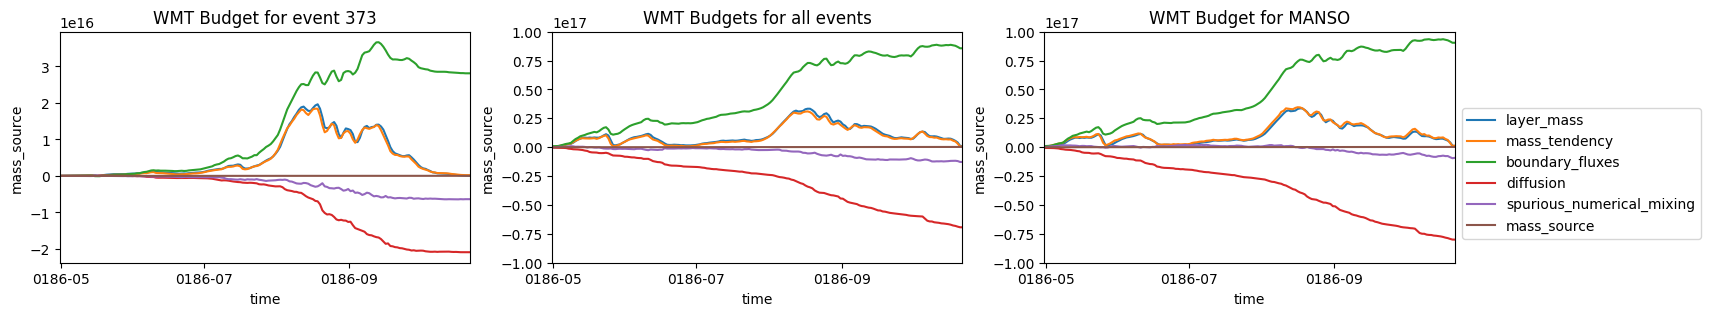

In [29]:
plt.figure(figsize=(18,3))

plt.subplot(1,3,1)

budget.layer_mass.where(wmt.thetao_l_target >= 29).sum("thetao_l_target").plot(label='layer_mass')

(budget.mass_tendency * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='mass_tendency')
(budget['boundary_fluxes'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='boundary_fluxes')
(budget['diffusion'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='diffusion')
(budget['spurious_numerical_mixing'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='spurious_numerical_mixing')
(budget['mass_source'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='mass_source')
plt.xlim(event_times.time[0].values,event_times.time[-1].values)
plt.title(f'WMT Budget for event {mhw}')

plt.subplot(1,3,2)
budgets_sum.layer_mass.where(wmt.thetao_l_target >= 29).sum("thetao_l_target").plot(label='layer_mass')
(budgets_sum.mass_tendency * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='mass_tendency')
(budgets_sum['boundary_fluxes'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='boundary_fluxes')
(budgets_sum['diffusion'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='diffusion')
(budgets_sum['spurious_numerical_mixing'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='spurious_numerical_mixing')
(budgets_sum['mass_source'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='mass_source')
plt.xlim(event_times.time[0].values,event_times.time[-1].values)
plt.ylim(-1e17, 1e17)
plt.title('WMT Budgets for all events')

plt.subplot(1,3,3)
wmt.layer_mass.where(wmt.thetao_l_target >= 29).sum("thetao_l_target").plot(label='layer_mass')
(wmt.mass_tendency * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='mass_tendency')
(-wmt['boundary_fluxes'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='boundary_fluxes')
(-wmt['diffusion'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='diffusion')
(-wmt['spurious_numerical_mixing'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='spurious_numerical_mixing')
(wmt['mass_source'] * 86400).cumsum('time').sel(thetao_l_target=29, method='nearest').plot(label='mass_source')
plt.xlim(event_times.time[0].values,event_times.time[-1].values)
plt.ylim(-1e17, 1e17)
plt.title('WMT Budget for MANSO')
plt.legend(bbox_to_anchor=(1, 0.2, 0.5, 0.5))

# plt.savefig('../figures/7d-rolling-mask-wmt-budgets.png',dpi=300)
plt.show()
# all_terms = Gsurf + Gmix + mass_source + mass_transport

In [189]:
def plot_wmt_budget(wmt, delta_M, idx_max, idx_form, idx_destroy):

    # back_color = "w"
    mass_source_color = "C2"
    mass_transport_color = "C4" # C0
    spurious_numerical_mixing_color = "C5"
    boundary_fluxes_color = "C1"
    diffusion_color = "C4"
    mass_tendency_color = "k" # "C0" "#48a0f8"
    sum_color = 'gray' # '#83d2fc'  #5ea9d1

    fig, ax = plt.subplots(figsize=(12,5))

    delta_M.isel(time=slice(0, idx_destroy[-1])).plot(ax=ax, 
                                                      label=r"$ \mathcal{M}(\Theta)$", 
                                                      color = mass_tendency_color, 
                                                      linewidth=4,
                                                      alpha=1
                                                     )

    delta_M.isel(time=slice(idx_form[0],idx_max.values)).plot(color='r',linestyle="-",linewidth=2)
    delta_M.isel(time=slice(idx_max.values,idx_destroy[-1])).plot(color='#48a0f8',linestyle="-",linewidth=2)

    Gsurf = (wmt['boundary_fluxes'] * 86400).cumsum('time').interp(thetao_l_target=29)
    Gsurf.plot(ax=ax, label=r"$\langle \mathcal{G}^{surf} \rangle$", color = boundary_fluxes_color, linewidth=2)

    diffusion = (wmt['diffusion'] * 86400).cumsum('time').interp(thetao_l_target=29)
    spur = (wmt['spurious_numerical_mixing'] * 86400).cumsum('time').interp(thetao_l_target=29)
    
    Gmix = diffusion+spur
    Gmix.plot(ax=ax, label=r"$\langle \mathcal{G}^{mix} \rangle$", color= diffusion_color, linewidth=2)

    mass_source = (wmt['mass_source'] * 86400).cumsum('time').interp(thetao_l_target=29)
    mass_source.plot(ax=ax, label=r"$-\langle \mathcal{S} \rangle$", color = mass_source_color, linewidth=2)

    mass_transport = (wmt.convergent_mass_transport * 86400).cumsum('time').interp(thetao_l_target=29)
    mass_transport.plot(label="mass_transport", color=mass_transport_color, linewidth=2)
    
    all_terms = Gsurf + Gmix + mass_source + mass_transport
    all_terms.plot(ax=ax, 
                   label=r"$\langle \mathcal{G}^{surf}+\mathcal{G}^{mix} \rangle$", 
                   color = sum_color, 
                   linestyle="--", 
                   linewidth=0.5
                  )

    ax.plot(delta_M.time.isel(time=idx_max), delta_M.isel(time=idx_max), 'wo',  markersize=8, markeredgecolor='k', label=r"$\max\{\mathcal{M}(\Theta)\}$")


    ## Formation and destruction phases
    
    start_point = (delta_M.time.isel(time=idx_max).values, delta_M[0])
    end_point = (delta_M.time.isel(time=idx_max).values, Gsurf.isel(time=idx_max).values)
    # ax.annotate('', xy=end_point, xytext=start_point, arrowprops=dict(arrowstyle='->', color='red', linewidth=linewidth))
    
    start_point = (delta_M.time.isel(time=idx_max.values).values, delta_M[0])
    end_point_des = (delta_M.time.isel(time=idx_max.values).values, Gmix.isel(time=idx_max.values).values)
    # ax.annotate('', xy=end_point_des, xytext=start_point, arrowprops=dict(arrowstyle='->', color='C0', linewidth=linewidth))
    
    fill_times_form = delta_M.time.isel(time=slice(0, idx_max.values+1)).values
    fill_deltaM_form = delta_M.isel(time=slice(0, idx_max.values+1)).values
    mass_source_limit = (wmt['mass_source'] * wmt.dt).cumsum('time').interp(thetao_l_target=29).isel(time=slice(0, idx_max.values+1)).values
    ax.fill_between(fill_times_form, mass_source_limit, fill_deltaM_form, color='red', alpha=0.3)
    
    fill_times_des = delta_M.time.isel(time=slice(idx_max.values, idx_destroy[-1])).values
    fill_deltaM_des = delta_M.isel(time=slice(idx_max.values, idx_destroy[-1])).values
    mass_source_limit = (wmt['mass_source'] * wmt.dt).cumsum('time').interp(thetao_l_target=29).isel(time=slice(idx_max.values, idx_destroy[-1])).values
    ax.fill_between(fill_times_des, mass_source_limit, fill_deltaM_des, color="#48a0f8", alpha=0.3) # diffusion_color '#209cfa'
    
    ##
    
    ax.tick_params(axis='both', which='major')
    ax.set_ylim(-0.4e+17, 0.4e+17)
    ax.set_xlim(wmt.time.values[0],wmt.time.values[-1])
    ax.set_title("")
    ax.set_ylabel(r"$ \mathcal{M}(\mathcal{t})$")
    ax.set_xlabel("")

    ax.grid(True, alpha=0.9)
    ax.legend(loc='lower left')

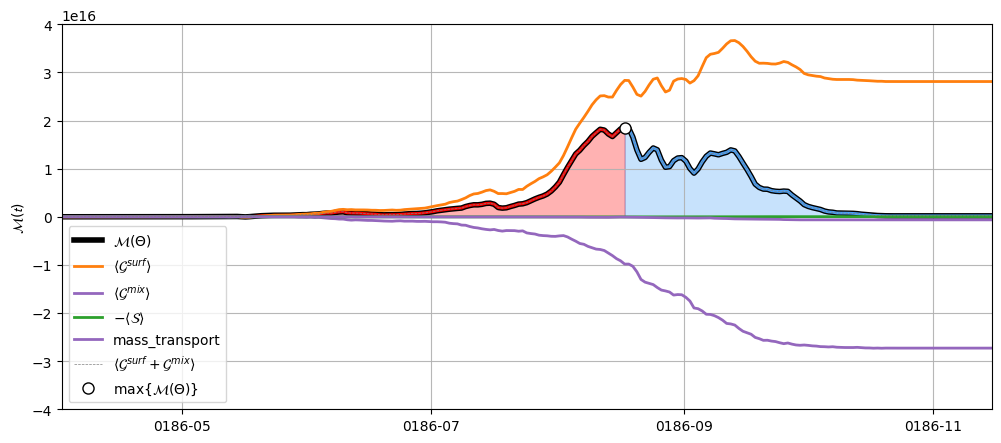

In [190]:
# plot_wmt_budget(wmt, delta_M, idx_max, idx_form, idx_destroy):
plot_wmt_budget(budgets.sel(mhw=id).sel(time=slice(t1,t2)), deltaM_event_dmdt, idx_max_event_dmdt, idx_form_event_dmdt, idx_destroy_event_dmdt)